# VECM (Vector Error Correction Model)을 기반 분석

비정상적인 시계열 변수들의 선형결합이 안정적인 과정이 될 때, 즉 공적분 관계가 존재하는 변수들에 대해 적용할 수 있다.  
(활용) 벡터오차수정 모형은 변수들의 장기적 균형관계와 단기적 동적관계를 동시에 이해하는 데 유용하기에 다양한 금융시장 실증분석에서 활용


## 1. 주가 데이터 로드 (pykrx) : 삼성전자 보통주와 우선주 종가 수집

In [1]:
from pykrx import stock
import pandas as pd
import numpy as np
import datetime

# 날짜 범위 설정
start_date = "2023-01-01"
end_date = "2025-06-25"
start_fmt = datetime.datetime.strptime(start_date, "%Y-%m-%d").strftime("%Y%m%d")
end_fmt = datetime.datetime.strptime(end_date, "%Y-%m-%d").strftime("%Y%m%d")

# 삼성전자 보통주와 우선주 종가 수집
common = stock.get_market_ohlcv_by_date(start_fmt, end_fmt, "005930")['종가']
preferred = stock.get_market_ohlcv_by_date(start_fmt, end_fmt, "005935")['종가']

# 데이터프레임 결합 및 정리
df = pd.concat([common, preferred], axis=1)
df.columns = ['Common', 'Preferred']
df.dropna(inplace=True)

# 로그변환
df_log = np.log(df)


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2.공적분 검정 (Johansen)

In [2]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen 공적분 검정
cj = coint_johansen(df_log, det_order=0, k_ar_diff=1)

print("📈 Johansen Trace Statistic:", cj.lr1)
print("📌 Critical Values (95%):", cj.cvt[:,1])

# 해석 기준: Trace Stat > Critical Value → 공적분 관계 존재


📈 Johansen Trace Statistic: [16.61764395  2.86057904]
📌 Critical Values (95%): [15.4943  3.8415]


In [ ]:
# 해석 기준: Trace Stat > Critical Value → 공적분 관계 존재

## 3. VECM 모형 적합

In [3]:
from statsmodels.tsa.vector_ar.vecm import VECM

# VECM 모형 생성 (공적분 rank=1로 지정)
vecm_model = VECM(df_log, k_ar_diff=1, coint_rank=1, deterministic='co')  # 'co' = constant in cointegration eq
vecm_result = vecm_model.fit()

print(vecm_result.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation Common
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0131      0.007     -1.806      0.071      -0.027       0.001
L1.Common        0.0961      0.085      1.130      0.258      -0.071       0.263
L1.Preferred    -0.0665      0.091     -0.733      0.464      -0.244       0.111
Det. terms outside the coint. relation & lagged endog. parameters for equation Preferred
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0006      0.007     -0.089      0.929      -0.014       0.013
L1.Common        0.2186      0.080      2.748      0.006       0.063       0.374
L1.Preferred    -0.1602      0.085     -1.887      0.059      -0.327       0.006
               

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 3.1. 각 식의 단기 동학 (Short-run Dynamics)

In [ ]:
# Equation for Common (삼성전자 보통주)
# 변수	계수 (coef)	해석
# const	-0.0131	단기 평균 회귀 수준, 유의수준 10%에서 유의성 borderline
# L1.Common	0.0961	보통주의 1기 전 수익률이 현재 보통주 수익률에 미치는 영향 (미약)
# L1.Preferred	-0.0665	우선주의 1기 전 수익률이 현재 보통주에 미치는 영향 (유의하지 않음)

In [ ]:
# Equation for Preferred (우선주)
# 변수	계수 (coef)	해석
# const	-0.0006	매우 작고 유의하지 않음
# L1.Common	0.2186 (p = 0.006)	보통주의 수익률이 우선주 수익률에 유의미한 영향을 미침
# L1.Preferred	-0.1602	우선주 자기회귀 계수 (p = 0.059로 경계선 유의성)

In [ ]:
# 해석 요약
# 보통주의 변화가 우선주에 영향을 미친다는 단기적인 정보 흐름이 있음 (L1.Common → Preferred 유의).
# 반대로, 우선주 → 보통주 영향은 유의하지 않음.

### 3.2. Loading Coefficients (α, 알파): 장기 균형으로의 복원 속도

In [ ]:
# 종목	α 계수 (ec1)	해석
# Common	-0.0404	장기균형에서 벗어날 때 보통주가 복원력 있음 (p ≈ 0.066)
# Preferred	-0.0017	거의 0에 가까움, 복원력 없음

# 즉, 삼성전자 보통주(Common) 쪽이 공적분 관계를 회복하는 주도적 역할을 한다는 뜻입니다. 우선주는 이에 따라가기만 하는 구조.

### 3.3. Cointegration Relation (beta, 장기 균형식)

In [ ]:
# log(Common) - 1.0472 * log(Preferred) ≈ const
# → 두 종목의 로그 가격 차이가 **평균을 중심으로 안정적(Stationary)**임을 의미
# → 장기적으로는 거의 1:1 비율로 움직임

## 4. 장단기 관계 해석 :  장기 관계 (공적분 벡터)

In [4]:
beta = vecm_result.beta  # 공적분 벡터
print("🔗 Long-run Cointegration Vector (beta):")
print(beta)


🔗 Long-run Cointegration Vector (beta):
[[ 1.        ]
 [-1.04719078]]


In [ ]:
#  (결과 해석)→ 두 주가는 거의 1:1 비율로 장기적으로 균형 유지

## 5. 단기 조정 속도 (alpha)

In [5]:
alpha = vecm_result.alpha
print("⚡ Short-run Adjustment Speed (alpha):")
print(alpha)


⚡ Short-run Adjustment Speed (alpha):
[[-0.04035821]
 [-0.00170804]]


In [ ]:
# alpha는 장기 균형에서 벗어났을 때, 각 자산이 얼마나 빠르게 복원하려 하는가를 보여줍니다.

# 예: alpha[0] = -0.2이면 → 보통주가 오차의 20% 정도를 다음 시점에 수정

# VECM을 기반으로 트레이딩 신호 생성 또는 잔차 기반 백테스트

## VECM 기반 신호 + 백테스트

C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


📈 VECM 기반 Pair Trading 성과 요약
Sharpe Ratio : 1.3495
Win Rate     : 25.66%
Max Drawdown : -4.34%


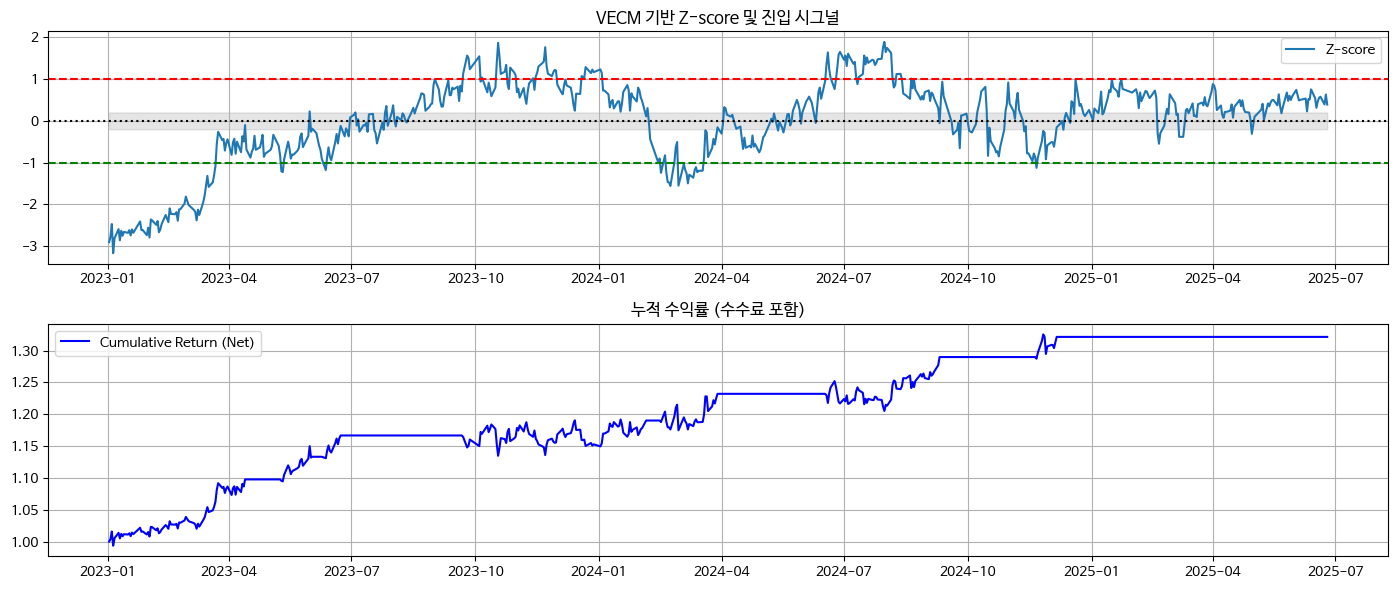

In [6]:
import pandas as pd
import numpy as np
from pykrx import stock
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
import matplotlib.pyplot as plt

# 1. 날짜 범위 및 종가 수집
start_date = "2023-01-01"
end_date = "2025-06-25"
start_fmt = pd.to_datetime(start_date).strftime("%Y%m%d")
end_fmt = pd.to_datetime(end_date).strftime("%Y%m%d")

common = stock.get_market_ohlcv_by_date(start_fmt, end_fmt, "005930")['종가']
preferred = stock.get_market_ohlcv_by_date(start_fmt, end_fmt, "005935")['종가']
df = pd.concat([common, preferred], axis=1)
df.columns = ['Common', 'Preferred']
df.dropna(inplace=True)
df_log = np.log(df)

# 2. Johansen 공적분 검정
cj = coint_johansen(df_log, det_order=0, k_ar_diff=1)
beta = cj.evec[:, 0]  # 첫 번째 공적분 벡터 사용

# 3. VECM 적합
vecm_model = VECM(df_log, k_ar_diff=1, coint_rank=1, deterministic='co')
vecm_result = vecm_model.fit()
alpha = vecm_result.alpha

# 4. 공적분 기반 스프레드 계산 (잔차 시계열)
spread = df_log @ beta
spread = spread - spread.mean()
zscore = (spread - spread.mean()) / spread.std()

# 5. z-score 기반 포지션 설정
entry_threshold = 1.0
exit_threshold = 0.2
position = pd.Series(index=zscore.index, dtype='float')
position[zscore > entry_threshold] = -1  # 보통주 숏 / 우선주 롱
position[zscore < -entry_threshold] = 1  # 보통주 롱 / 우선주 숏
position[zscore.abs() < exit_threshold] = 0  # 청산
position = position.ffill().fillna(0)

# 6. 스프레드 수익률 (보통주 - 우선주)
ret_common = df['Common'].pct_change()
ret_preferred = df['Preferred'].pct_change()
spread_return = position.shift(1) * (ret_common - ret_preferred)

# 7. 수수료 반영
commission = 0.002
trade_flag = position.diff().abs() > 0
net_return = spread_return - trade_flag * commission
cumulative_return = (1 + net_return.fillna(0)).cumprod()

# 8. 백테스트 성과 요약
sharpe = (net_return.mean() / net_return.std()) * np.sqrt(252)
win_rate = (net_return > 0).mean()
max_dd = (cumulative_return / cumulative_return.cummax() - 1).min()

# 9. 결과 출력
print("📈 VECM 기반 Pair Trading 성과 요약")
print(f"Sharpe Ratio : {sharpe:.4f}")
print(f"Win Rate     : {win_rate:.2%}")
print(f"Max Drawdown : {max_dd:.2%}")

# 10. 시각화
plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(zscore, label="Z-score")
plt.axhline(entry_threshold, color='r', linestyle='--')
plt.axhline(-entry_threshold, color='g', linestyle='--')
plt.axhline(0, color='black', linestyle=':')
plt.fill_between(zscore.index, -exit_threshold, exit_threshold, color='grey', alpha=0.2)
plt.title("VECM 기반 Z-score 및 진입 시그널")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(cumulative_return, label="Cumulative Return (Net)", color='blue')
plt.title("누적 수익률 (수수료 포함)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 주요 해석
# 항목	설명
# spread	VECM의 공적분 벡터로 생성된 잔차 (mean-reverting)
# z-score	표준화 잔차 → 매매 신호 생성 지표
# position	±1 진입, 0.2 이하 청산 룰 적용
# net_return	수수료 반영된 일일 수익률
# Sharpe, Win Rate, Max DD	전략 평가 지표